# 05: Fimbulwinter Validation (bf16)

**Question:** Does our Rich model exhibit the fimbulwinter dynamics we expect?

We're looking for the signature:
1. Dead token centroid moves in a straight line away from origin (coherent swarm)
2. Movement rate decelerates steeply (Adam variance catching up)
3. Displacement distribution shifts toward zero (everything freezes)

**Critical:** We train in bfloat16. The bf16 quantization floor is what causes fimbulwinter—gradients below ULP (~1e-3 at typical magnitudes) round to zero, actually freezing dead tokens. Without bf16, tokens slow down but never truly freeze.

**Minimal instrumentation:** We don't need full W[t]. Just track:
- Dead token displacement magnitudes per step
- Centroid position (or distance from origin) over time

If this works, Rich becomes our official Goldilocks model.

## Parameters

In [ ]:
# === Parameters ===

# Paths
DATA_DIR = "data"
TOKENIZER_PATH = f"{DATA_DIR}/tokenizer.json"
TOKENS_PATH = f"{DATA_DIR}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{DATA_DIR}/token_census.json"

# Rich architecture (the winner)
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
BATCH_SIZE = 8
DROPOUT = 0.0

# Training
TRAINING_STEPS = 2000  # Enough to see fimbulwinter onset
LEARNING_RATE = 1e-3

# Precision: bf16 to get the quantization floor that causes fimbulwinter
import torch
MODEL_DTYPE = torch.bfloat16

# Displacement binning thresholds
# These might need tuning based on what we see
SMALL_THRESHOLD = 1e-4  # Below this = "frozen"
LARGE_THRESHOLD = 1e-2  # Above this = "large movement"

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tokenizers import Tokenizer
import json
import time
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

## Load Data & Dead Token IDs

In [ ]:
# Load tokenizer
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Loaded tokenizer: {vocab_size:,} tokens")

# Load cached tokenized corpus (fast!)
print(f"Loading cached tokens from {TOKENS_PATH}...")
tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

# Load dead token census
with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)

dead_token_ids = set(census['dead_token_ids'])
print(f"✓ Dead tokens: {len(dead_token_ids):,}")

## Dataset & Model

In [24]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))

# Create dataset and model (bf16!)
dataset = TokenDataset(all_tokens, SEQ_LEN)
model = GPT(vocab_size, D_MODEL, N_HEADS, N_LAYERS, D_FF, SEQ_LEN, DROPOUT).to(device).to(MODEL_DTYPE)

n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model: {n_params:,} parameters ({MODEL_DTYPE})")
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Model: 1,057,024 parameters (torch.bfloat16)
✓ Dataset: 100,000 samples


## Training with Displacement Tracking

In [25]:
def get_dead_embeddings(model, dead_ids):
    """Extract embeddings for dead tokens."""
    W = model.tok_emb.weight.detach()
    dead_ids_tensor = torch.tensor(list(dead_ids), device=W.device)
    return W[dead_ids_tensor].clone()

def compute_displacement_stats(W_prev, W_curr):
    """Compute displacement magnitudes between two embedding snapshots."""
    displacements = W_curr - W_prev
    magnitudes = torch.norm(displacements, dim=1)  # L2 norm per token
    return magnitudes.cpu().float().numpy()

def bin_displacements(magnitudes, small_thresh, large_thresh):
    """Bin displacements into frozen/small/large categories."""
    frozen = (magnitudes < small_thresh).sum()
    large = (magnitudes > large_thresh).sum()
    small = len(magnitudes) - frozen - large
    return frozen, small, large

print("✓ Tracking functions defined")

✓ Tracking functions defined


In [26]:
print("="*70)
print("FIMBULWINTER VALIDATION RUN (bf16)")
print("="*70)
print(f"Model: Rich ({N_LAYERS}L/{D_MODEL}D/{N_HEADS}H), dtype: {MODEL_DTYPE}")
print(f"Training: {TRAINING_STEPS:,} steps, batch {BATCH_SIZE}")
print(f"Tracking: {len(dead_token_ids):,} dead token displacements")
print()

# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
loader_iter = iter(loader)

# Tracking arrays
history = {
    'step': [],
    'loss': [],
    'centroid_dist': [],      # Distance of dead token centroid from origin
    'mean_displacement': [],   # Mean displacement magnitude
    'frozen_count': [],        # Count of "frozen" tokens
    'small_count': [],         # Count of "small movement" tokens  
    'large_count': [],         # Count of "large movement" tokens
}

# Get initial dead embeddings
W_dead_prev = get_dead_embeddings(model, dead_token_ids)
initial_centroid = W_dead_prev.mean(dim=0)

model.train()
start_time = time.perf_counter()

pbar = tqdm(range(TRAINING_STEPS), desc="Training")
for step in pbar:
    # Get batch
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    # Training step
    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
    loss.backward()
    optimizer.step()
    
    # Track dead token dynamics
    W_dead_curr = get_dead_embeddings(model, dead_token_ids)
    
    # Centroid distance from origin
    centroid = W_dead_curr.mean(dim=0)
    centroid_dist = torch.norm(centroid).item()
    
    # Displacement statistics
    magnitudes = compute_displacement_stats(W_dead_prev, W_dead_curr)
    frozen, small, large = bin_displacements(magnitudes, SMALL_THRESHOLD, LARGE_THRESHOLD)
    
    # Record
    history['step'].append(step)
    history['loss'].append(loss.item())
    history['centroid_dist'].append(centroid_dist)
    history['mean_displacement'].append(magnitudes.mean())
    history['frozen_count'].append(frozen)
    history['small_count'].append(small)
    history['large_count'].append(large)
    
    # Update for next iteration
    W_dead_prev = W_dead_curr
    
    # Progress bar
    if step % 100 == 0:
        pbar.set_postfix(loss=f"{loss.item():.3f}", frozen=f"{frozen}/{len(dead_token_ids)}")

elapsed = time.perf_counter() - start_time
print(f"\n✓ Training complete in {elapsed:.1f}s ({TRAINING_STEPS/elapsed:.1f} steps/s)")

FIMBULWINTER VALIDATION RUN (bf16)
Model: Rich (4L/128D/2H), dtype: torch.bfloat16
Training: 18,000 steps, batch 8
Tracking: 1,914 dead token displacements



Training:   0%|          | 0/18000 [00:00<?, ?it/s]


✓ Training complete in 186.9s (96.3 steps/s)


## Visualize Fimbulwinter

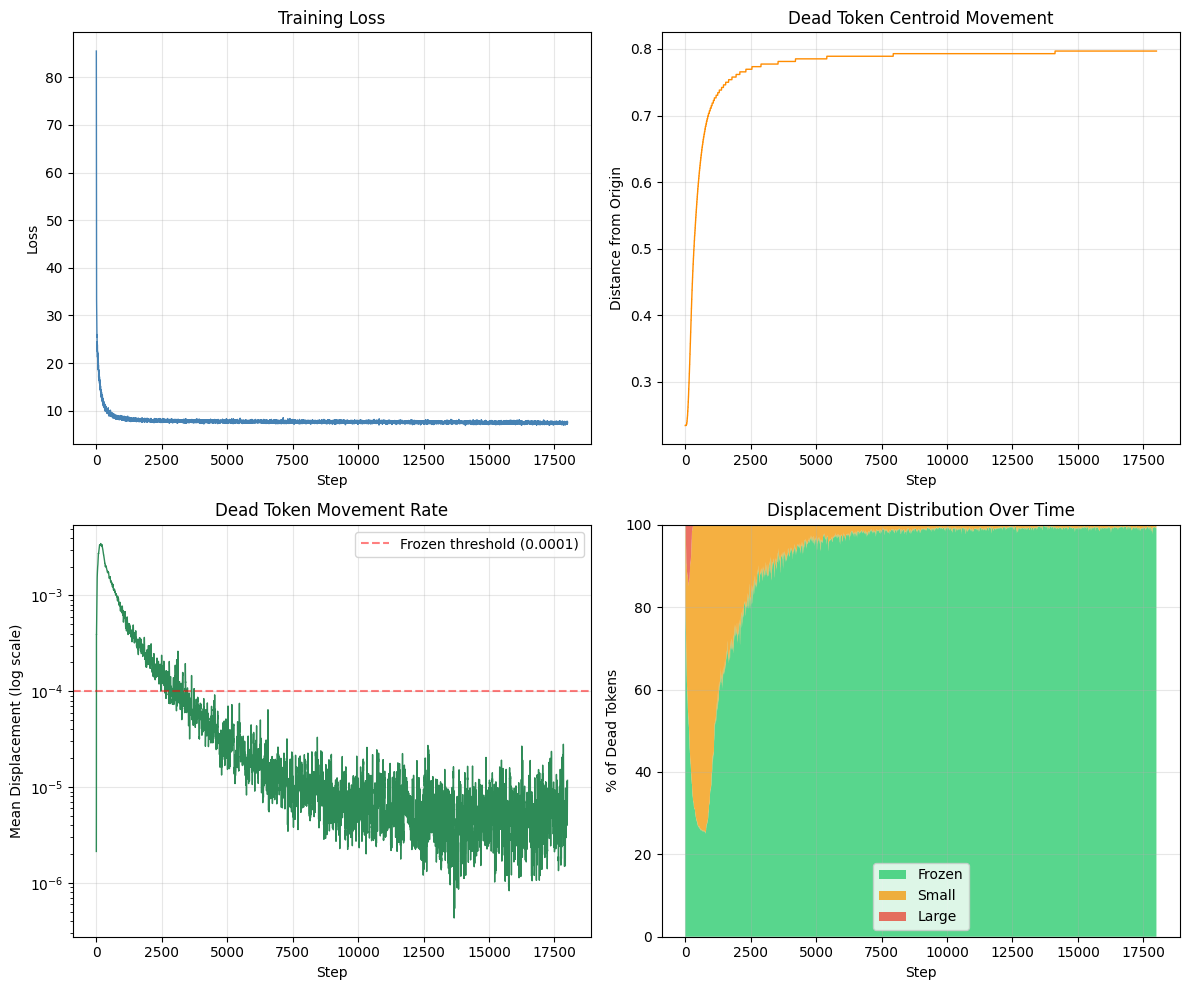

✓ Saved: fimbulwinter_validation@200.png, fimbulwinter_validation@72.png


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

steps = history['step']

# 1. Loss curve
ax1 = axes[0, 0]
ax1.plot(steps, history['loss'], color='steelblue', linewidth=1)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# 2. Centroid distance from origin
ax2 = axes[0, 1]
ax2.plot(steps, history['centroid_dist'], color='darkorange', linewidth=1)
ax2.set_xlabel('Step')
ax2.set_ylabel('Distance from Origin')
ax2.set_title('Dead Token Centroid Movement')
ax2.grid(True, alpha=0.3)

# 3. Mean displacement over time (should decrease = fimbulwinter)
ax3 = axes[1, 0]
ax3.semilogy(steps, history['mean_displacement'], color='seagreen', linewidth=1)
ax3.axhline(SMALL_THRESHOLD, color='red', linestyle='--', alpha=0.5, label=f'Frozen threshold ({SMALL_THRESHOLD})')
ax3.set_xlabel('Step')
ax3.set_ylabel('Mean Displacement (log scale)')
ax3.set_title('Dead Token Movement Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Stacked area: displacement distribution over time
ax4 = axes[1, 1]
n_dead = len(dead_token_ids)
frozen_pct = [100 * f / n_dead for f in history['frozen_count']]
small_pct = [100 * s / n_dead for s in history['small_count']]
large_pct = [100 * l / n_dead for l in history['large_count']]

ax4.stackplot(steps, frozen_pct, small_pct, large_pct,
              labels=['Frozen', 'Small', 'Large'],
              colors=['#2ecc71', '#f39c12', '#e74c3c'],
              alpha=0.8)
ax4.set_xlabel('Step')
ax4.set_ylabel('% of Dead Tokens')
ax4.set_title('Displacement Distribution Over Time')
ax4.legend(loc='best')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fimbulwinter_validation@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('fimbulwinter_validation@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: fimbulwinter_validation@200.png, fimbulwinter_validation@72.png")

## Summary

In [28]:
print("\n" + "="*70)
print("FIMBULWINTER VALIDATION RESULTS")
print("="*70)

# Check for fimbulwinter signature
early_displacement = np.mean(history['mean_displacement'][:100])
late_displacement = np.mean(history['mean_displacement'][-100:])
displacement_ratio = early_displacement / late_displacement

early_frozen = np.mean(history['frozen_count'][:100])
late_frozen = np.mean(history['frozen_count'][-100:])

centroid_start = history['centroid_dist'][0]
centroid_end = history['centroid_dist'][-1]
centroid_movement = centroid_end - centroid_start

print(f"\nCentroid movement:")
print(f"  Start: {centroid_start:.4f}")
print(f"  End: {centroid_end:.4f}")
print(f"  Total displacement: {centroid_movement:.4f}")

print(f"\nDisplacement slowdown:")
print(f"  Early (first 100 steps): {early_displacement:.6f}")
print(f"  Late (last 100 steps): {late_displacement:.6f}")
print(f"  Slowdown factor: {displacement_ratio:.1f}×")

print(f"\nFreezing progression:")
print(f"  Early frozen: {early_frozen:.0f}/{len(dead_token_ids)} ({100*early_frozen/len(dead_token_ids):.1f}%)")
print(f"  Late frozen: {late_frozen:.0f}/{len(dead_token_ids)} ({100*late_frozen/len(dead_token_ids):.1f}%)")

# Verdict
print(f"\n" + "*"*70)
if displacement_ratio > 5 and late_frozen > early_frozen:
    print("★ FIMBULWINTER CONFIRMED ★")
    print("  Dead tokens are freezing as expected.")
else:
    print("⚠ FIMBULWINTER UNCLEAR")
    print("  Results inconclusive. May need to adjust thresholds or train longer.")
print("*"*70)


FIMBULWINTER VALIDATION RESULTS

Centroid movement:
  Start: 0.2344
  End: 0.7969
  Total displacement: 0.5625

Displacement slowdown:
  Early (first 100 steps): 0.001796
  Late (last 100 steps): 0.000006
  Slowdown factor: 301.1×

Freezing progression:
  Early frozen: 1301/1914 (68.0%)
  Late frozen: 1902/1914 (99.4%)

**********************************************************************
★ FIMBULWINTER CONFIRMED ★
  Dead tokens are freezing as expected.
**********************************************************************
